### ETL - Extract, Transform, Load data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
torch.set_grad_enabled(True)

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='../data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
import torch.nn as nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        # 1 input 
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        return t

In [4]:
network = Network()
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=100
    ,shuffle=True
)

In [5]:
batch = next(iter(train_loader))

In [6]:
images, labels = batch

#### calculating the lossm

In [7]:
preds = network(images)

In [8]:
loss = F.cross_entropy(preds, labels) # Calculating the loss

In [9]:
loss.item()

2.3060920238494873

In [10]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [11]:
get_num_correct(preds, labels)

8

#### calculating the gradients

In [12]:
network.conv1.weight.grad

In [13]:
loss.backward()

In [14]:
network.conv1.weight.grad.shape

torch.Size([6, 1, 5, 5])

#### updating the weights

In [15]:
optimizer = optim.Adam(network.parameters(), lr=0.01)
optimizer.step() # Updating the weights

In [16]:
# When the step() function is called, the optimizer updates the weights using the gradients that are stored
# in the network's parameters. This means that we should expect our loss to be reduced if we pass the same 
# batch through the network again. Checking this, we can see that this is indeed the case:

In [17]:
preds = network(images)

In [18]:
loss.item()

2.3060920238494873

In [19]:
loss = F.cross_entropy(preds, labels)
loss.item()

2.2771904468536377

In [20]:
get_num_correct(preds, labels)

8

#### summary of the above using a single batch

In [21]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # Get Batch
images, labels = batch

preds = network(images) # Pass Batch
loss = F.cross_entropy(preds, labels) # Calculate Loss

loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())

loss1: 2.2985470294952393
loss2: 2.2616004943847656


### training for an epoch - for loop

In [22]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

total_loss = 0
total_correct = 0

for batch in train_loader: # Get Batch
    images, labels = batch 

    preds = network(images) # Pass Batch
    loss = F.cross_entropy(preds, labels) # Calculate Loss

    optimizer.zero_grad() # this is used because the weights would be accumulated if not reset to zero
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights

    total_loss += loss.item()
    total_correct += get_num_correct(preds, labels)

print(
    "epoch:", 0, 
    "total_correct:", total_correct, 
    "loss:", total_loss
)

epoch: 0 total_correct: 47703 loss: 328.3513718545437


In [23]:
total_correct / len(train_set)

0.79505

#### Training With Multiple Epochs

In [24]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(10):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: 51629 loss: 228.97742287814617
epoch 1 total_correct: 52273 loss: 207.5476776957512
epoch 2 total_correct: 52554 loss: 201.7034831047058
epoch 3 total_correct: 52942 loss: 190.7755706757307
epoch 4 total_correct: 53040 loss: 188.88697639107704
epoch 5 total_correct: 53154 loss: 184.33232875913382
epoch 6 total_correct: 53376 loss: 180.0489300340414
epoch 7 total_correct: 53449 loss: 177.78430704027414
epoch 8 total_correct: 53559 loss: 178.18154555559158
epoch 9 total_correct: 53554 loss: 173.7305375188589


#### get predictions

In [25]:
len(train_set)

60000

In [27]:
len(train_set.targets)

60000

In [28]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [29]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

In [30]:
preds_correct = get_num_correct(train_preds, train_set.targets)
print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 53712
accuracy: 0.8952


#### get confusion matrix

In [32]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [33]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [34]:
stacked = torch.stack(
    (
        train_set.targets
        ,train_preds.argmax(dim=1)
    )
    ,dim=1
)

In [35]:
stacked.shape

torch.Size([60000, 2])

In [36]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [37]:
cmt = torch.zeros(10,10, dtype=torch.int64)

In [38]:
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [39]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [40]:
cmt

tensor([[5582,   19,  110,   60,    8,    0,  191,    0,   30,    0],
        [  11, 5907,    1,   57,    7,    1,   14,    0,    2,    0],
        [  74,    5, 5045,   58,  614,    1,  198,    0,    5,    0],
        [ 239,   42,   17, 5494,  102,    0,   94,    0,   12,    0],
        [   4,    6,  364,  328, 5067,    0,  223,    0,    8,    0],
        [   1,    0,    0,    0,    0, 5872,    0,   74,    4,   49],
        [1306,   14,  686,  115,  563,    1, 3304,    1,   10,    0],
        [   0,    0,    0,    0,    0,   73,    3, 5799,    4,  121],
        [  28,    4,   19,    9,   17,   10,   40,    4, 5869,    0],
        [   0,    0,    0,    0,    0,    6,    2,  213,    6, 5773]])

#### sklearn confusion matrix

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [44]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))

In [45]:
cm

array([[5582,   19,  110,   60,    8,    0,  191,    0,   30,    0],
       [  11, 5907,    1,   57,    7,    1,   14,    0,    2,    0],
       [  74,    5, 5045,   58,  614,    1,  198,    0,    5,    0],
       [ 239,   42,   17, 5494,  102,    0,   94,    0,   12,    0],
       [   4,    6,  364,  328, 5067,    0,  223,    0,    8,    0],
       [   1,    0,    0,    0,    0, 5872,    0,   74,    4,   49],
       [1306,   14,  686,  115,  563,    1, 3304,    1,   10,    0],
       [   0,    0,    0,    0,    0,   73,    3, 5799,    4,  121],
       [  28,    4,   19,    9,   17,   10,   40,    4, 5869,    0],
       [   0,    0,    0,    0,    0,    6,    2,  213,    6, 5773]])

In [46]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

Confusion matrix, without normalization
[[5582   19  110   60    8    0  191    0   30    0]
 [  11 5907    1   57    7    1   14    0    2    0]
 [  74    5 5045   58  614    1  198    0    5    0]
 [ 239   42   17 5494  102    0   94    0   12    0]
 [   4    6  364  328 5067    0  223    0    8    0]
 [   1    0    0    0    0 5872    0   74    4   49]
 [1306   14  686  115  563    1 3304    1   10    0]
 [   0    0    0    0    0   73    3 5799    4  121]
 [  28    4   19    9   17   10   40    4 5869    0]
 [   0    0    0    0    0    6    2  213    6 5773]]


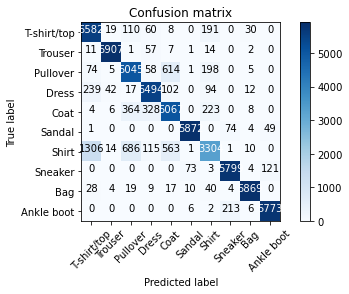

In [49]:
plot_confusion_matrix(cm, train_set.classes)